In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
import matplotlib.pyplot as plt


In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

In [3]:
import pickle
import numpy as np
pickle_in=open('/content/drive/My Drive/CLASS Project/balanced_image_data.pickle','rb')
dataset=pickle.load(pickle_in)
pickle_in.close()
dataset=np.array(dataset)
print(dataset.shape)
dataset=dataset/255.0
dataset=np.repeat(dataset,3,-1)
print(dataset.shape)



dataset=dataset.reshape((10342,100,100,3))
print(dataset.shape)

(10342, 100, 100)
(10342, 100, 300)
(10342, 100, 100, 3)


In [4]:
pickle_in=open('/content/drive/My Drive/CLASS Project/balanced_label.pickle','rb')
label=pickle.load(pickle_in)
pickle_in.close()
label=np.array(label)

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(dataset,label,stratify=label,test_size=0.1,random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
y_train=keras.utils.to_categorical(y_train)
y_test=keras.utils.to_categorical(y_test)


(9307, 100, 100, 3)
(1035, 100, 100, 3)
(9307,)
(1035,)


In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9307, 100, 100, 3)
(1035, 100, 100, 3)
(9307, 3)
(1035, 3)


In [7]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [9]:
def import_base_model():
    IMG_SIZE=[100,100]
    den=DenseNet121(input_shape=IMG_SIZE+[3],weights='imagenet',include_top=False)

    #for layer in den.layers:
    #layer.trainable=False
    xcep=Xception(input_shape=IMG_SIZE+[3],weights='imagenet',include_top=False)
    incp=InceptionV3(input_shape=IMG_SIZE+[3],weights='imagenet',include_top=False)
    res=ResNet50(input_shape=IMG_SIZE+[3],weights='imagenet',include_top=False)
    mob=MobileNet(input_shape=IMG_SIZE+[3],weights='imagenet',include_top=False)
    for layer in den.layers:
        layer.trainable = False

    for layer in incp.layers:
        layer.trainable = False

    for layer in res.layers:
        layer.trainable = False
    for layer in xcep.layers:
        layer.trainable = False
    for layer in mob.layers:
        layer.trainable = False        
    return den,xcep,incp,res,mob

## Concatenation

In [10]:
den,xcep,incp,res,mob=import_base_model()

17227776/17225924 [==============================] - 0s 0us/step


In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from keras.applications.densenet import preprocess_input as process_densenet
from keras.applications.inception_v3 import preprocess_input as process_inception
from keras.applications.mobilenet import preprocess_input as process_mobilenet
from keras.applications.xception import preprocess_input as process_xception
#inp=Input((100,100,3))
#resnet_process = Lambda(process_resnet)(inp)
#res_net = res(resnet_process)
#x_resnet = GlobalMaxPool2D()(res_net)
#x_resnet = Dense(3, activation='relu')(x_resnet)

In [12]:
inp=Input((100,100,3))
resnet_process = Lambda(process_resnet)(inp)
res_net = res(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)


densenet_process = Lambda(process_densenet)(inp)
densenet_net = den(densenet_process)
x_densenet = GlobalMaxPool2D()(densenet_net)
x_densenet = Dense(128, activation='relu')(x_densenet)


mobile_process = Lambda(process_mobilenet)(inp)
mobile_net = den(mobile_process)
x_mobile = GlobalMaxPool2D()(mobile_net)
x_mobile = Dense(128, activation='relu')(x_mobile)

incp_process = Lambda(process_inception)(inp)
incp_net = incp(incp_process)
x_incp = GlobalMaxPool2D()(incp_net)
x_incp = Dense(128, activation='relu')(x_incp)

xcep_process = Lambda(process_xception)(inp)
xcep_net = xcep(xcep_process)
x_xcep = GlobalMaxPool2D()(xcep_net)
x_xcep = Dense(128, activation='relu')(x_xcep)

In [13]:
x = Concatenate()([x_resnet, x_densenet, x_mobile,x_incp,x_xcep])
out = Dense(3, activation='softmax')(x)

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
# fit the model
#history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=50, verbose=0)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)
model = Model(inp, out)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [16]:
#es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
#hist_con=model.fit(X_train,y_train,epochs=20, validation_data=(X_test,y_test), callbacks=[es], verbose = 1)
hist_con=model.fit(X_train,y_train,epochs=20, validation_data=(X_test,y_test), verbose = 1)

Epoch 1/20
291/291 [==============================] - 47s 162ms/step - loss: 0.6158 - accuracy: 0.6528 - f1_m: 0.6493 - precision_m: 0.6650 - recall_m: 0.6445 - val_loss: 0.4756 - val_accuracy: 0.6696 - val_f1_m: 0.6746 - val_precision_m: 0.6759 - val_recall_m: 0.6734
Epoch 2/20
291/291 [==============================] - 39s 133ms/step - loss: 0.5029 - accuracy: 0.6698 - f1_m: 0.6687 - precision_m: 0.6712 - recall_m: 0.6680 - val_loss: 0.4707 - val_accuracy: 0.6715 - val_f1_m: 0.4917 - val_precision_m: 1.0000 - val_recall_m: 0.3311
Epoch 3/20
291/291 [==============================] - 39s 133ms/step - loss: 0.4836 - accuracy: 0.6640 - f1_m: 0.6593 - precision_m: 0.6731 - recall_m: 0.6555 - val_loss: 0.4720 - val_accuracy: 0.6705 - val_f1_m: 0.6749 - val_precision_m: 0.6756 - val_recall_m: 0.6743
Epoch 4/20
291/291 [==============================] - 39s 133ms/step - loss: 0.4744 - accuracy: 0.6635 - f1_m: 0.6611 - precision_m: 0.6670 - recall_m: 0.6593 - val_loss: 0.4868 - val_accuracy:

In [17]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)

33/33 [==============================] - 4s 114ms/step - loss: 0.4628 - accuracy: 0.6725 - f1_m: 0.6772 - precision_m: 0.6772 - recall_m: 0.6772


In [18]:
print('loss ',loss)
print('accuracy ',accuracy)
print('f1 score ',f1_score)
print('precision ',precision)
print('recall ',recall)

loss  0.4628244638442993
accuracy  0.6724637746810913
f1 score  0.6771693229675293
precision  0.6771693825721741
recall  0.6771693825721741


In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100, 100, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 100, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 100, 100, 3)  0           input_6[0][0]                    
_______________________________________________________________________________________

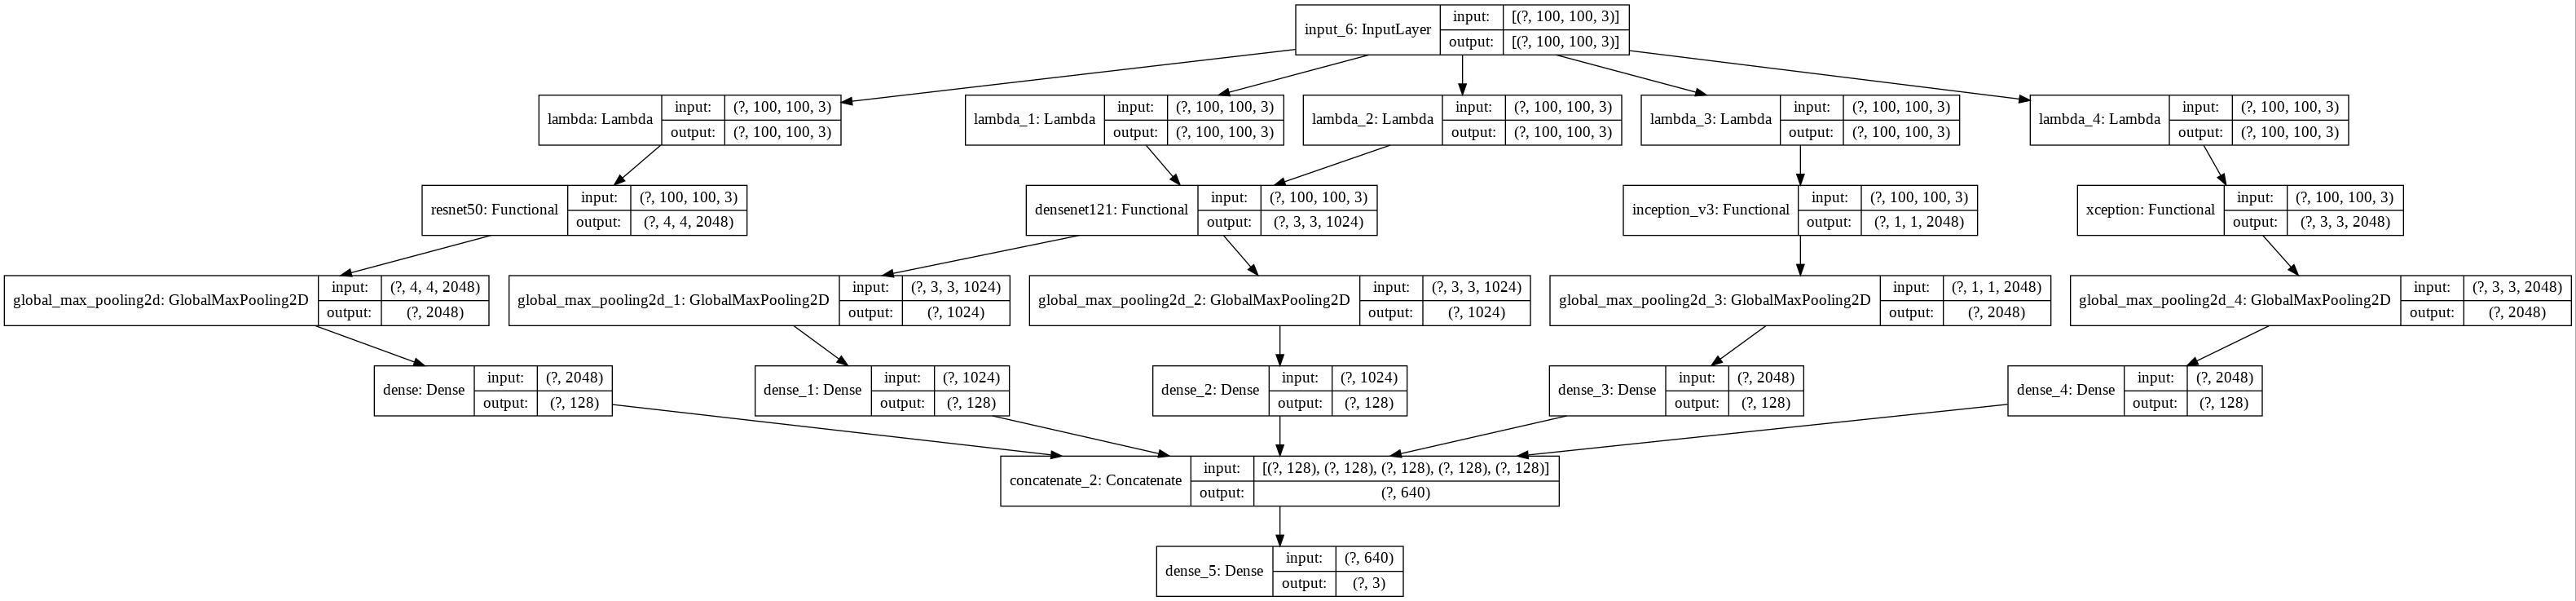

In [ ]:
keras.utils.plot_model(model,to_file='/content/drive/My Drive/CLASS Project/saved models/EnsembleCON.jpg',show_shapes=True)

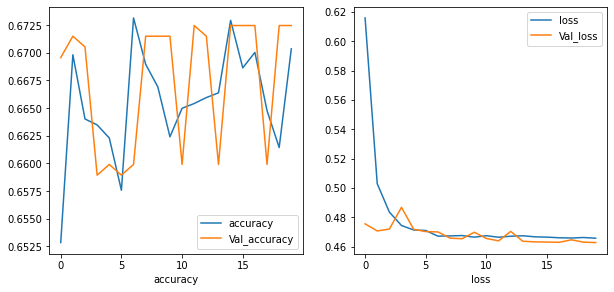

In [20]:
#plotting accurayc and loss plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(hist_con.history['accuracy'],label='accuracy')
plt.plot(hist_con.history['val_accuracy'],label='Val_accuracy')
plt.xlabel('accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_con.history['loss'],label='loss')
plt.plot(hist_con.history['val_loss'],label='Val_loss')
plt.xlabel('loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/CLASS Project/saved models/EnsembleConcatenate')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [ ]:
inp=Input((100,100,3))
resnet_process = (process_resnet)(inp)
res_net = res(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)


densenet_process = (process_densenet)(inp)
densenet_net = den(densenet_process)
x_densenet = GlobalMaxPool2D()(densenet_net)
x_densenet = Dense(128, activation='relu')(x_densenet)


mobile_process = (process_mobilenet)(inp)
mobile_net = den(mobile_process)
x_mobile = GlobalMaxPool2D()(mobile_net)
x_mobile = Dense(128, activation='relu')(x_mobile)

incp_process = (process_inception)(inp)
incp_net = incp(incp_process)
x_incp = GlobalMaxPool2D()(incp_net)
x_incp = Dense(128, activation='relu')(x_incp)

xcep_process = (process_xception)(inp)
xcep_net = xcep(xcep_process)
x_xcep = GlobalMaxPool2D()(xcep_net)
x_xcep = Dense(128, activation='relu')(x_xcep)

In [ ]:
x = Average()([x_resnet, x_densenet, x_mobile,x_incp,x_xcep])
out = Dense(3, activation='softmax')(x)

In [ ]:
model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
hist_add=model.fit(X_train,y_train,epochs=50, validation_data=(X_test,y_test), callbacks=[es], verbose = 1)

Epoch 1/50
291/291 [==============================] - 41s 141ms/step - loss: 0.5776 - accuracy: 0.6488 - val_loss: 0.4812 - val_accuracy: 0.6686
Epoch 2/50
291/291 [==============================] - 34s 118ms/step - loss: 0.4940 - accuracy: 0.6668 - val_loss: 0.4808 - val_accuracy: 0.6696
Epoch 3/50
291/291 [==============================] - 34s 116ms/step - loss: 0.4855 - accuracy: 0.6605 - val_loss: 0.5134 - val_accuracy: 0.6570
Epoch 4/50
291/291 [==============================] - 34s 115ms/step - loss: 0.4797 - accuracy: 0.6663 - val_loss: 0.4768 - val_accuracy: 0.6696
Epoch 5/50
291/291 [==============================] - 34s 117ms/step - loss: 0.4771 - accuracy: 0.6630 - val_loss: 0.4853 - val_accuracy: 0.6715
Epoch 6/50
291/291 [==============================] - 34s 115ms/step - loss: 0.4720 - accuracy: 0.6624 - val_loss: 0.4738 - val_accuracy: 0.6580
Epoch 7/50
291/291 [==============================] - 33s 115ms/step - loss: 0.4697 - accuracy: 0.6773 - val_loss: 0.4684 - val_ac

In [ ]:
score=model.evaluate(X_test,y_test)

33/33 [==============================] - 3s 100ms/step - loss: 0.4675 - accuracy: 0.6725


In [ ]:
print('test score ',score[0])
print('test accuracy ',score[1])

test score  0.46746835112571716
test accuracy  0.6724637746810913


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 100, 100, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 100, 100, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_BiasAdd_1 (TensorFl [(None, 100, 100, 3) 0           tf_op_layer_RealDiv[0][0]        
_______________________________________________________________________________________

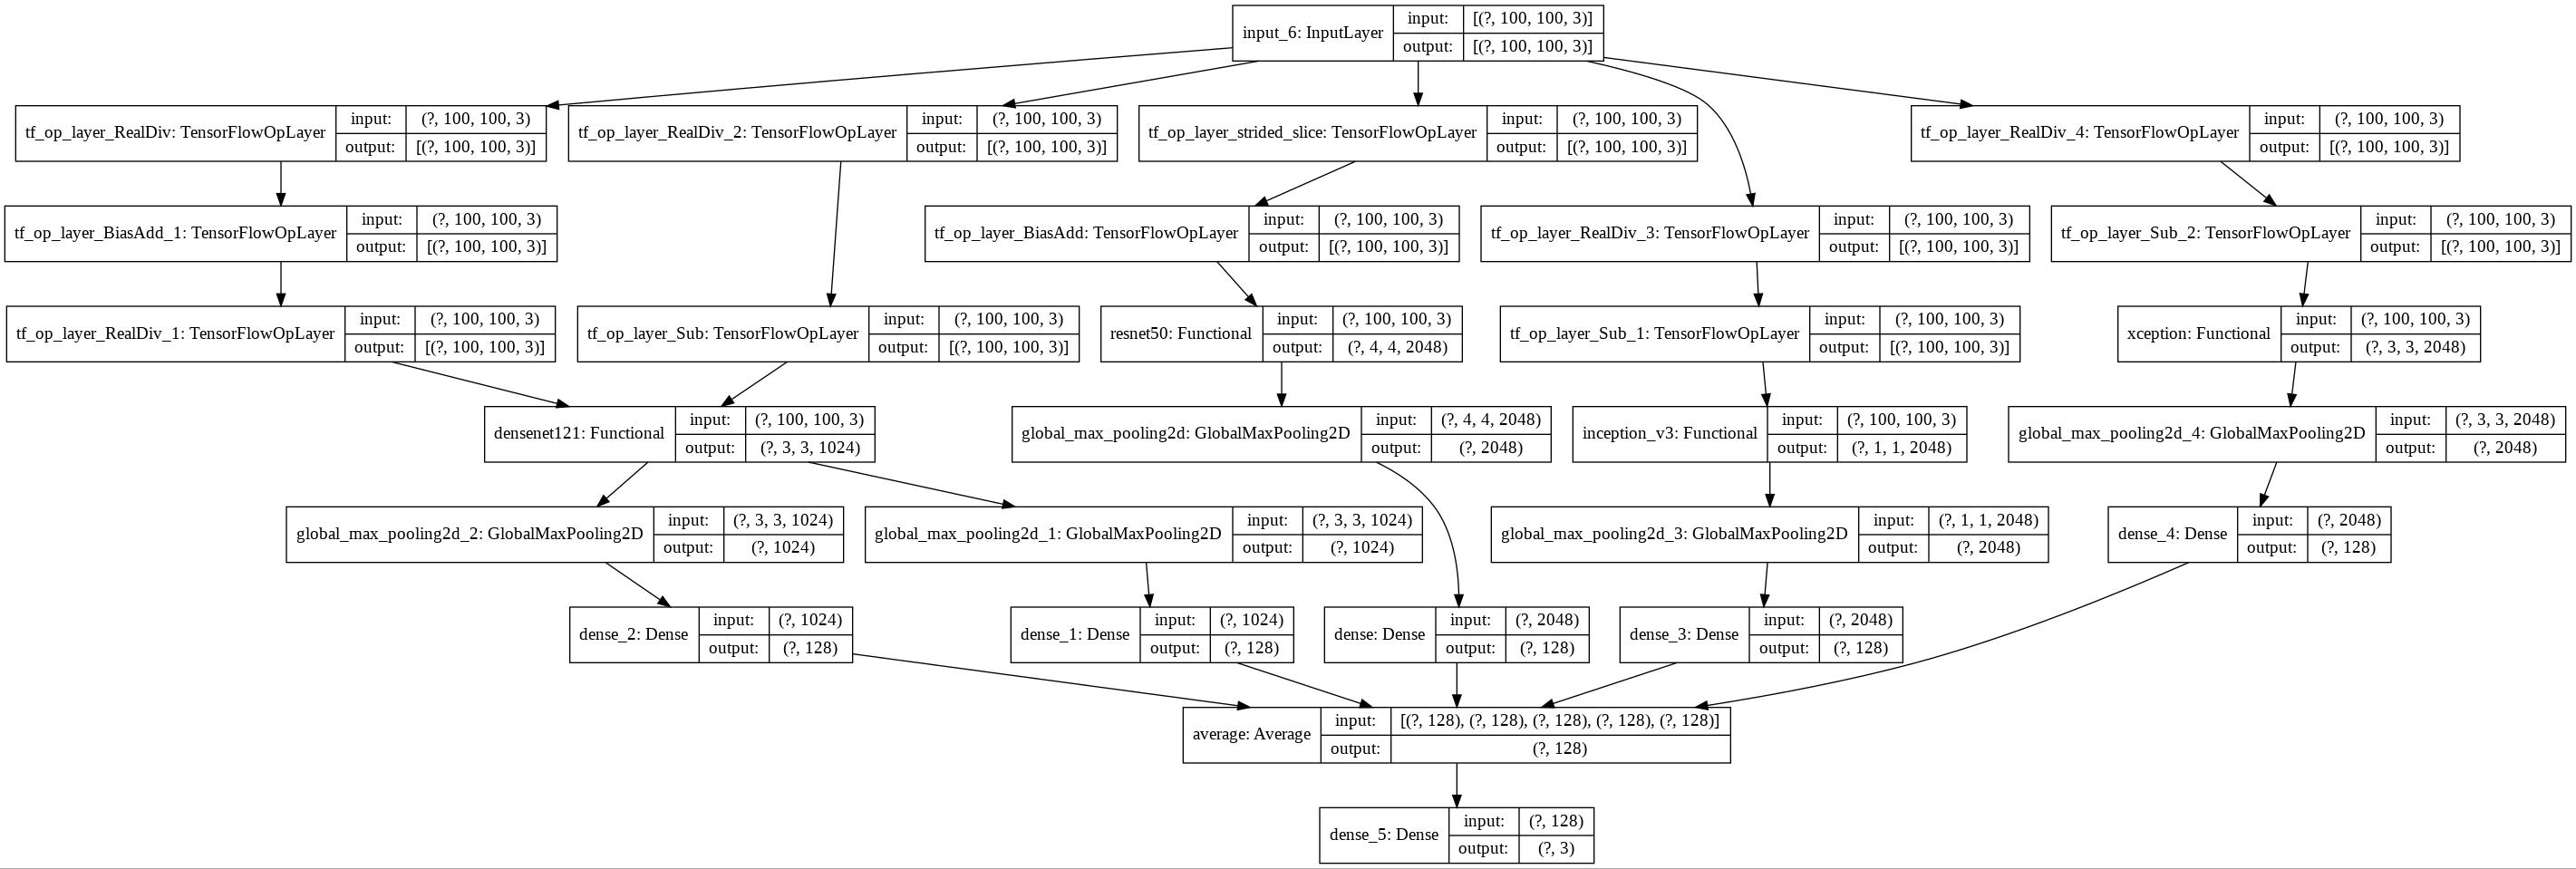

In [ ]:
keras.utils.plot_model(model,to_file='/content/drive/My Drive/CLASS Project/saved models/Ensemble_Avg.jpg',show_shapes=True)

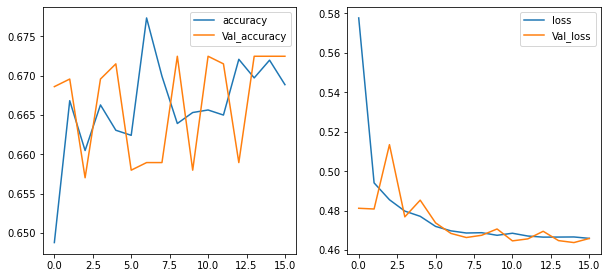

In [ ]:
#plotting accurayc and loss plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(hist_add.history['accuracy'],label='accuracy')
plt.plot(hist_add.history['val_accuracy'],label='Val_accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_add.history['loss'],label='loss')
plt.plot(hist_add.history['val_loss'],label='Val_loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/CLASS Project/saved models/Ensemble_AVG')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/CLASS Project/saved models/Ensemble_AVG/assets
